In [11]:
# config
import os

# specify the shape of input for our network
image_shape = (28, 28, 1)

# specify the batch size and number of epochs
batch_size = 64
epochs = 100

# define path to base output directory
base_output = 'output'

# use base output path to derive the path to serialized model along with training history plot
model_path = os.path.sep.join([base_output, 'siamese_model'])
plot_path = os.path.sep.join([base_output, 'plot.png'])

In [2]:
# Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

def build_siamese_model(input_shape, embedding_dim=48):
    # specify inputs for feature extractor network
    inputs = Input(input_shape)
    
    # define first set of CONV=>RELU=>POOL=>Dropout layers
    x = Conv2D(64, (2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    # define second set of CONV=>RELU=>POOL=>Dropout layers
    x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # prepare the final outputs
    pooled_output = GlobalAveragePooling2D()(x)
    outputs = Dense(embedding_dim)(pooled_output)

    # build the model
    model = Model(inputs, outputs)
    
    # return model to calling function
    return model

In [3]:
# Utils
#imports
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# image pair generation
def make_pairs(images, labels):
    # initialize 2 empty lists to hold (image, image) pairs and 
    # labels to indicate if a pair is positive or negative
    pair_images = []
    pair_labels = []
    
    # calculate the total number of classes present in dataset and then build a list of
    # indexes for each class label that provides indexes for all examples with a given label
    num_classes = len(np.unique(labels))
    idx = [np.where(labels==i)[0] for i in range(0, num_classes)]
    
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to current iteration
        current_image = images[idxA]
        label = labels[idxA]
        
        # randomly pic an image that belong to same class label
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        
        # prepare positive pair and update images and labels lists respectively
        pair_images.append([current_image, pos_image])
        pair_labels.append([1])
        
        # grab the indicies for each of the class labels not equal to current label and 
        # randomly pick an image corresponding to a label not equal to current label
        neg_idx = np.where(labels!=label)[0]
        neg_image = images[np.random.choice(neg_idx)]
        
        # prepare a negative pair of images and update our lists
        pair_images.append([current_image, neg_image])
        pair_labels.append([0])
        
    return (np.array(pair_images), np.array(pair_labels))

def euclidean_distance(vectors):
    # unpack vectors into seperate lists
    (featsA, featsB) = vectors
    
    # compute the sum of squared distances between vectors
    sum_squared = K.sum(K.square(featsA - featsB), axis = 1, keepdims=True)
    
    # return the euclidean distance between vectors
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

def plot_training(H, plot_path):
    # construct a plot that plots and saves training history
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(H.history['loss'], label='train_loss')
    plt.plot(H.history['val_loss'], label='val_loss')
    plt.plot(H.history['accuracy'], label='train_acc')
    plt.plot(H.history['val_accuracy'], label='val_accuracy')
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='lower left')
    plt.savefig(plot_path)

In [4]:
# contrastlive_loss
import tensorflow.keras.backend as K
import tensorflow as tf

def constrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted class label
    # type (otherwise we run the riskof having two seperate data types, causing 
    # tensorflow to error out)
    y = tf.cast(y, preds.dtype)
    
    # calculate the constrastive loss between true labels and predicted labels
    squared_preds = K.square(preds)
    squared_margin = K.square(K.maximum(margin-preds, 0))
    loss = K.mean(y * squared_preds + (1 - y) * squared_margin)
    
    return loss

[INFO] loading MNIST dataset...
[INFO] Preparing positive and negative pairs...
[INFO] building Siamese network...
[INFO] compiling model...
[INFO] training model...
Epoch 1/100
1875/1875 [==============================] - 23s 7ms/step - loss: 0.2004 - val_loss: 0.1700
Epoch 2/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1766 - val_loss: 0.1536
Epoch 3/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1636 - val_loss: 0.1394
Epoch 4/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1554 - val_loss: 0.1317
Epoch 5/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1492 - val_loss: 0.1253
Epoch 6/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1458 - val_loss: 0.1238
Epoch 7/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1434 - val_loss: 0.1233
Epoch 8/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1407 - val_loss: 0.1173
Ep

KeyError: ignored

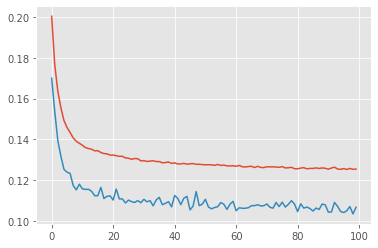

In [7]:
# Train network
from tensorflow.keras.models import Model
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import tensorflow
import numpy as np

# load the mnist dataset and scale pixcel values between the range of [0, 1]
print('[INFO] loading MNIST dataset...')
((trainX, trainY), (testX, testY)) = mnist.load_data()
trainX = trainX/255.0
testX = testX/255.0

# add a chanel dimension to data
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# prepare positive and negative pairs
print('[INFO] Preparing positive and negative pairs...')
(pair_train, label_train) = make_pairs(trainX, trainY)
(pair_test, label_test) = make_pairs(testX, testY)

# configure siamese network
print('[INFO] building Siamese network...')
image_A = Input(shape=image_shape)
image_B = Input(shape=image_shape)
feature_extractor = build_siamese_model(image_shape)
featsA = feature_extractor(image_A)
featsB = feature_extractor(image_B)

# build a siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[image_A, image_B], outputs=distance)

# compile model
print('[INFO] compiling model...')
model.compile(loss=constrastive_loss, optimizer='adam')

# train model
print('[INFO] training model...')
history = model.fit(
            [pair_train[:, 0], pair_train[:, 1]], label_train[:],
            validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
            batch_size=batch_size, epochs=epochs)

# serialize model to disk
print('[INFO] saving model...')
tensorflow.keras.models.save_model(model, model_path)

# plot training history
print('[INFO] plotting training history...')
plot_training(history, plot_path)

[INFO] loading test dataset...
[INFO] loading siamese model...


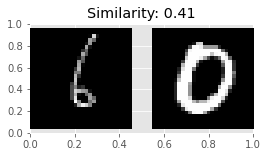

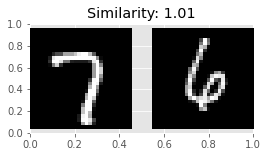

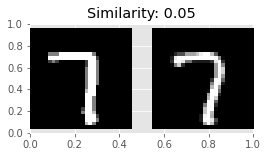

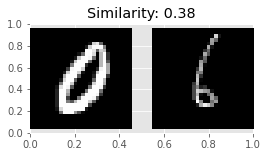

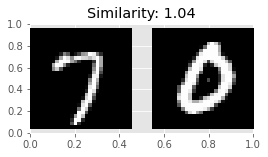

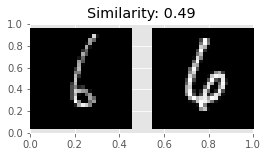

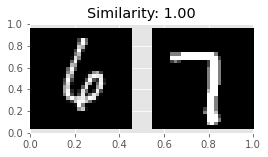

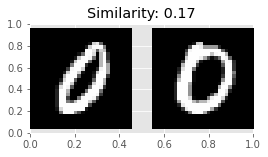

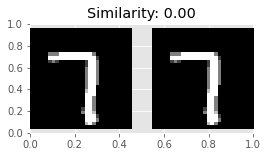

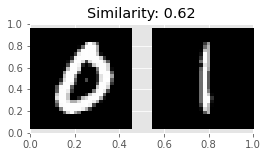

In [21]:
# Predictions
# imports
#from tensorflow.keras.models import load_model
from tensorflow import keras
from imutils.paths import list_images
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import argparse

# input to network
test_input = 'examples'

# grab the test dataset image paths and randomly generate a total of 10 image pairs
print('[INFO] loading test dataset...')
test_image_paths = list(list_images(test_input))
np.random.seed(42)
pairs = np.random.choice(test_image_paths, size=(10, 2))

# load model from disk
print('[INFO] loading siamese model...')
#model = load_model('output\siamese_model\saved_model')
model = keras.models.load_model('/content/output/siamese_model', compile=False)

# loop over all image pairs
for (i, (path_A, path_B)) in enumerate(pairs):
    # load both images and convert them to grayscale
    image_A = cv.imread(path_A, 0)
    image_B = cv.imread(path_B, 0)
    
    # create a copy of both images for visualization
    orig_A = image_A.copy()
    orig_B = image_B.copy()
    
    # add channel dimension to both images
    image_A = np.expand_dims(image_A, axis=-1)
    image_B = np.expand_dims(image_B, axis=-1)
    
    # add batch dimension to both images
    image_A = np.expand_dims(image_A, axis=0)
    image_B = np.expand_dims(image_B, axis=0)
    
    # scale pixel values to a range of [0, 1]
    image_A = image_A/255.0
    image_B = image_B/255.0
    
    # use our siamese model to make predictions on image pair, indicating whether or not
    # images belong to same class
    preds = model.predict([image_A, image_B])
    proba = preds[0][0]
    
    # initialize the figure 
    fig = plt.figure(f'Pair: {i+1}', figsize=(4, 2))
    plt.title(f'Similarity: {proba:.2f}')
    
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(orig_A, cmap=plt.cm.gray)
    plt.axis('off')
    
    # show first image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(orig_B, cmap=plt.cm.gray)
    plt.axis('off')
    
    plt.show